In [ ]:
%pip install sklearn
%pip install pillow
%pip install torchvision
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Datasets**

In [2]:
import PIL as Image
import torch
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#Preparing the dataset
annotations = pd.read_csv("Datasets/annotations.csv")
HP = annotations.iloc[:,1] == "HP"
SSA = annotations.iloc[:,1] == "SSA"
annotations["HP"] = HP
annotations["SSA"] = SSA
t_annotations = annotations[annotations["Partition"]=="train"]

train_annotations, val_annotations = train_test_split(t_annotations, train_size=0.8, stratify=t_annotations["HP"])

# Just to confirm if the distribution is the same 
print(len(train_annotations[HP] == True), len(train_annotations))
print(len(val_annotations[HP] == True), len(val_annotations))
test_annotations = annotations[annotations["Partition"]=="test"]
root_dir = "Datasets/images/"

class Plyops(Dataset):
  def __init__(self, annotations, root_dir, transform = None) -> None:
    self.annotations = annotations
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)

    if self.transform:
      image = self.transform(image)
    
    y_label = torch.tensor([int(self.annotations.iloc[index, 4]),int(self.annotations.iloc[index, 5])])
    return (image, y_label)
  

train_dataset = Plyops(train_annotations, root_dir)
val_dataset = Plyops(val_annotations, root_dir)
test_dataset = Plyops(test_annotations, root_dir)

batch_size = 256

train_dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size), 'val': DataLoader(val_dataset, batch_size=batch_size)}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataloaders['train']), 'val': len(train_dataloaders['val']), 'test': len(test_dataloader)}

1236 1740
309 435


/var/folders/hl/86tbqlkd413g631jyj246ld00000gn/T/ipykernel_74507/2894673893.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(train_annotations[HP] == True), len(train_annotations))
/var/folders/hl/86tbqlkd413g631jyj246ld00000gn/T/ipykernel_74507/2894673893.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(val_annotations[HP] == True), len(val_annotations))


**Image** **Patching**

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from  einops.einops import rearrange

def transform_image(image, patch_size):
  """If H*W*C is the dimensions of the image, we should return N vectors of size
  (P**2)*C, where P is the patch size and N = H*W/P i.e the number of patches
  We use einops to rearrange

  image: A four dimensional tensor

  patch_size: int
  """
  assert(image.shape[1]*image.shape[2]%patch_size == 0)
  image = rearrange(image, 'b h w c -> b c h w')
  return rearrange(image, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)

#Testing

image = torch.rand(size=[1,9,9,1])
image = transform_image(image, 3)
assert(image.shape == torch.Size([1,9,9]))

image = torch.rand(size=[1,9,9, 3])
image = transform_image(image, 3)
assert(image.shape == torch.Size([1, 9, 27]))

**Helper Models**

In [4]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, dropout = 0.):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.act1 = nn.GELU()
    self.drop1 = nn.Dropout(dropout)
    self.l2 = nn.Linear(hidden_dim, input_dim)
    self.drop2 = nn.Dropout(dropout)

  def forward(self, x):
    x = self.drop1(self.act1(self.l1(x)))
    x = self.drop2(self.l2(x))
    return x

#simple test to see if dimensions match up
mlp = MLP(5,6, 0.1)
mlp(torch.ones(size=(1,5,5))).shape


torch.Size([1, 5, 5])

**Models**

In [5]:
from einops import repeat

class PatchEmbedding(nn.Module):
  """This is the first part of the vision transformer"""
  def __init__(self, num_channels, image_size, patch_size, embedding_dim):
    super(PatchEmbedding, self).__init__()
    #size parameters
    self.patch_size = patch_size
    self.embedding_dim = embedding_dim
    self.image_size = image_size
    num_patches = (image_size//patch_size)**2
    #Need num channels for the below
    self.proj = nn.Linear((patch_size**2)*num_channels, embedding_dim)
    self.cls_token = nn.Parameter(torch.rand(1,1,embedding_dim))
    #num patches is wrong
    self.pos_embedding = nn.Parameter(torch.rand(1, num_patches + 1, embedding_dim))

  def forward(self, img):
    #transforms the image
    img = transform_image(img, self.patch_size)
    img = self.proj(img)
    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = img.shape[0])
    img = torch.cat([cls_tokens, img], dim = 1)
    img += self.pos_embedding
    return img

In [6]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim, n_heads, hidden_dim, dropout=0):
    super(TransformerEncoder, self).__init__()
    #Required parameters
    self.embedding_dim = embedding_dim
    self.n_heads = n_heads

    self.n1 = nn.LayerNorm(embedding_dim)
    self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=n_heads, dropout=dropout)
    self.n2 = nn.LayerNorm(embedding_dim)
    self.mlp = MLP(embedding_dim, hidden_dim)

  def forward(self, x):
    z = self.n1(x)
    y = self.attention(z,z,z)[0] + x
    x = self.mlp(self.n2(y)) + y
    return x

#simple test to see if dimensions add up
te = TransformerEncoder(3,3,3)
te(torch.ones(size = (1,7,3))).shape

torch.Size([1, 7, 3])

In [7]:
class ViT(nn.Module):
  def __init__(self, num_channels, image_size, patch_size, embedding_dim, n_heads, hidden_dim,n_layers, num_classes, dropout=0):
    super(ViT, self).__init__()
    self.patch_embedding = PatchEmbedding(num_channels, image_size, patch_size, embedding_dim)
    self.transformer_encoder = TransformerEncoder(embedding_dim, n_heads, hidden_dim, dropout)
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.final_layer = nn.Linear(embedding_dim, num_classes)
    self.n_layers = n_layers
    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    x = self.patch_embedding(x)
    for _ in range(self.n_layers):
      x = self.transformer_encoder(x)
    y = self.layer_norm(x[:,0,:])
    y = self.final_layer(y)
    y = self.softmax(y)
    return y

#short test to see if dimensions checks out
image = torch.ones(size = (3, 9,9, 1))
vit = ViT(1, 9, 3, 4, 4, 7, 7, 2)
vit(image).shape

torch.Size([3, 2])

**Training and Testing**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def visualize(*args, labels):
  n = len(args[0])
  x = np.arange(0,n, 1)
  assert len(args) == len(labels), "Each list must have a corresponding label"
  #Defining the functions used for plotting
  for i in range(len(args)):
    assert len(args[i]) == n, "incorrect number of values"
    plt.plot(x, args[i], label = labels[i])
  plt.xlim(0,n-1)
  plt.xticks(range(0,n-1))
  plt.ylim(0,1)
  plt.title("Model Evaluation")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.legend()
  plt.show()

def visualize_training(*args):
  labels = ["Precision", "Recall", "F1", "Specificity"]
  visualize(*args, labels= labels)

def visualize_testing(c_matrix):
  pass

In [ ]:
from numpy import mean
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


def training_loop(dataloader, model, epochs, loss_function, optimizer, scheduler = None):
  epoch_losses = []
  epoch_precisions = []
  epoch_recalls = []
  epoch_f1_scores = []
  epoch_specificities = []
  for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    batch_tn = []
    batch_fp = []
    batch_tp = []
    batch_fn = []
    batch_losses = []
    for x in ['train', 'val']:
      if x == 'train':
        model.train()
      else:
        model.eval()
      for (data, label) in dataloader[x]:
        data = data.to(torch.float32)
        label = label.to(torch.float32)
        data, label = data.to(device), label.to(device)
        output = model(data)
        output.to(device)
        loss = loss_function(output, label)
        optimizer.zero_grad()
        with torch.no_grad():
          predictions = torch.argmax(output.to('cpu'), 1)
          label = torch.argmax(label.to('cpu'), 1)
          tn, fp, fn, tp = confusion_matrix(label, predictions, labels=[0,1]).ravel()

        if x == 'train':
          loss.backward()
          optimizer.step()
        else:
          batch_losses.append(loss.item())
          batch_tn.append(tn)
          batch_fp.append(fp)
          batch_tp.append(tp)
          batch_fn.append(fn)

    epoch_loss = mean(batch_losses)
    epoch_losses.append(epoch_loss)
    epoch_tn, epoch_fp, epoch_tp, epoch_fn = sum(batch_tn), sum(batch_fp), sum(batch_tp), sum(batch_fn)
    
    if scheduler:
        scheduler.step(epoch_loss)

    epoch_precision = epoch_tp/(epoch_tp + epoch_fp) if epoch_tp + epoch_fp != 0 else 0
    epoch_precisions.append(epoch_precision)
    epoch_recall = epoch_tp/(epoch_tp + epoch_fn) if epoch_tp + epoch_fp != 0 else 1
    epoch_recalls.append(epoch_recall)
    epoch_f1 = (2*epoch_recall*epoch_precision)/(epoch_recall + epoch_precision) if epoch_recall + epoch_precision != 0 else 0
    epoch_f1_scores.append(epoch_f1)
    epoch_specificity = epoch_tn/(epoch_tn + epoch_fp) if epoch_tn + epoch_fp != 0 else 1
    epoch_specificities.append(epoch_specificity)
          
    print("Precision: " + str(epoch_precision) 
          + " F1: " + str(epoch_f1))
    print("Recall: " + str(epoch_recall) + " Specificity: " + str(epoch_specificity))
    print("Loss: " + str(epoch_loss))

  return [epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_specificities]


In [9]:
import torch.optim as optim
#We will vary embedding_dim, hidden_dim, n_heads, n_layers, later
num_channels = 3
image_size = 224
patch_size = 16
embedding_dim = 768
hidden_dim = 3072
n_heads = 12
n_layers = 12
num_classes = 2
#large learning rate since not much time to train
lr = 5e-4

model = ViT(num_channels=num_channels, image_size=image_size, 
            patch_size=patch_size, embedding_dim=embedding_dim, 
            hidden_dim=hidden_dim, n_heads=n_heads, n_layers=n_layers, num_classes=num_classes)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-2, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 50

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer)
visualize_training(args)


Epoch: 0
Epoch 0 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6206, grad_fn=<DivBackward0>)
Epoch: 1
Epoch 1 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6098, grad_fn=<DivBackward0>)
Epoch: 2
Epoch 2 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6064, grad_fn=<DivBackward0>)
Epoch: 3
Epoch 3 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6050, grad_fn=<DivBackward0>)
Epoch: 4
Epoch 4 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6051, grad_fn=<DivBackward0>)
Epoch: 5


KeyboardInterrupt: 

: 

Lets test the model

In [ ]:
import itertools
from tabulate import tabulate

def test(test_dataloader, model):
  model.to(device)
  model.eval()
  #Assumes that batch_size = len(test_dataloader)
  for data, label in test_dataloader:
    data = data.to(torch.float32)
    label = label.to(torch.float32)
    data, label = data.to(device), label.to(device)
    output = model(data)
    with torch.no_grad():
      predictions = torch.argmax(output.to('cpu'), 1)
      label = torch.argmax(label.to('cpu'), 1)
      return confusion_matrix(label, predictions, labels=[0,1]), classification_report(label, predictions, output_dict=True)

def visualize_testing(cm):
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0,1], rotation=45)
  plt.yticks(tick_marks, [0,1])
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  

/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/madhavgopakumar/.pyenv/versions/3.10.7/envs/cv-project-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

[[617   0]
 [360   0]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.631525 │        1 │   0.774153 │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0        │        0 │   0        │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


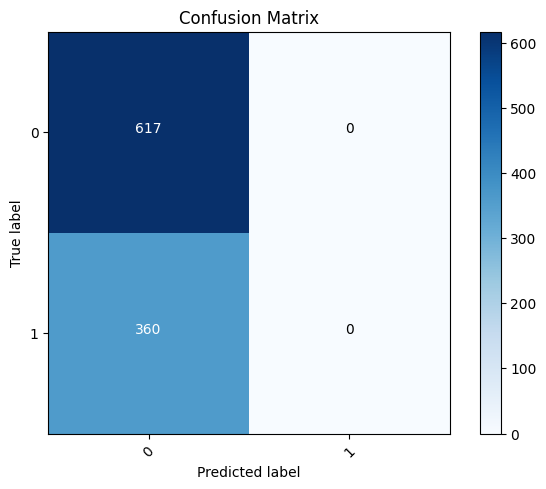

In [ ]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

**Balancing the Dataset**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
#We are going to try Random oversampling with image augmentation first
train_transforms2 = transforms.Compose([transforms.ToPILImage(), 
                                       transforms.Resize(size=(227, 227)), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.RandomAdjustSharpness(sharpness_factor=0.8),
                                       transforms.RandomGrayscale(),transforms.ToTensor()])

#We are going to apply random transformation to each of the training examples, and see their effect on the model in addition
#Note that t_annotations is only the training data not the testing
ros = RandomOverSampler(random_state=0)
t_annotations_data, t_annotations_target = ros.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_ros, val_annotations_ros = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])

#Below is the training datasets with transformations applied
train_dataset_ros = Plyops(train_annotations_ros, root_dir, train_transforms2)
val_dataset_ros = Plyops(val_annotations_ros, root_dir, train_transforms2)

batch_size = 32

train_dataloaders_ros = {'train': DataLoader(train_dataset_ros, batch_size=batch_size), 
                                                    'val': DataLoader(val_dataset_ros, batch_size=batch_size)}

3090 3090


In [ ]:
import torch.optim as optim
#We will vary embedding_dim, hidden_dim, n_heads, n_layers, later
num_channels = 3
image_size = 224
patch_size = 16
embedding_dim = 768
hidden_dim = 3072
n_heads = 12
n_layers = 12
num_classes = 2
#large learning rate since not much time to train
lr = 5e-4

model = ViT(num_channels=num_channels, image_size=image_size, 
            patch_size=patch_size, embedding_dim=embedding_dim, 
            hidden_dim=hidden_dim, n_heads=n_heads, n_layers=n_layers, num_classes=num_classes)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-2, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 50

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer)
visualize_training(args)


Epoch: 0
Epoch 0 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6206, grad_fn=<DivBackward0>)
Epoch: 1
Epoch 1 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6098, grad_fn=<DivBackward0>)
Epoch: 2
Epoch 2 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6064, grad_fn=<DivBackward0>)
Epoch: 3
Epoch 3 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6050, grad_fn=<DivBackward0>)
Epoch: 4
Epoch 4 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6051, grad_fn=<DivBackward0>)
Epoch: 5


KeyboardInterrupt: 

: 

[[340 277]
 [282  78]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.546624 │ 0.551053 │   0.54883  │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.219718 │ 0.216667 │   0.218182 │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


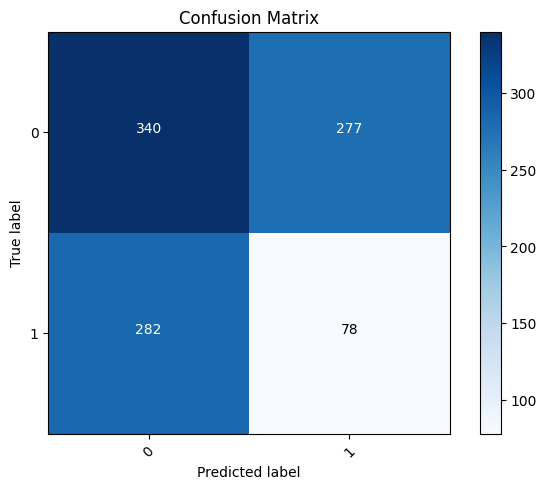

In [ ]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

**Random Undersampling**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
#Now lets try random undersampling 
rus = RandomUnderSampler(random_state=0)
t_annotations_data, t_annotations_target = rus.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_rus, val_annotations_rus = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])

#Below is the training datasets
train_dataset_rus = Plyops(train_annotations_rus, root_dir, transform)
val_dataset_rus = Plyops(val_annotations_rus, root_dir, transform)

batch_size = 32

train_dataloaders_rus = {'train': DataLoader(train_dataset_rus, batch_size=batch_size), 
                                                    'val': DataLoader(val_dataset_rus, batch_size=batch_size)}
print(len(train_dataset_ros), len(train_dataset_rus))

1260 1260
2472 1008


In [ ]:
import torch.optim as optim
#We will vary embedding_dim, hidden_dim, n_heads, n_layers, later
num_channels = 3
image_size = 224
patch_size = 16
embedding_dim = 768
hidden_dim = 3072
n_heads = 12
n_layers = 12
num_classes = 2
#large learning rate since not much time to train
lr = 5e-4

model = ViT(num_channels=num_channels, image_size=image_size, 
            patch_size=patch_size, embedding_dim=embedding_dim, 
            hidden_dim=hidden_dim, n_heads=n_heads, n_layers=n_layers, num_classes=num_classes)

loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-2, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
#Small number of epochs since we dont have the computational resources
epochs = 50

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer)
visualize_training(args)


Epoch: 0
Epoch 0 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6206, grad_fn=<DivBackward0>)
Epoch: 1
Epoch 1 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6098, grad_fn=<DivBackward0>)
Epoch: 2
Epoch 2 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6064, grad_fn=<DivBackward0>)
Epoch: 3
Epoch 3 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6050, grad_fn=<DivBackward0>)
Epoch: 4
Epoch 4 average precision: 0.0 average f1: 0.0
average recall: 0.0 average loss: tensor(0.6051, grad_fn=<DivBackward0>)
Epoch: 5


KeyboardInterrupt: 

: 

[[340 277]
 [282  78]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.546624 │ 0.551053 │   0.54883  │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.219718 │ 0.216667 │   0.218182 │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


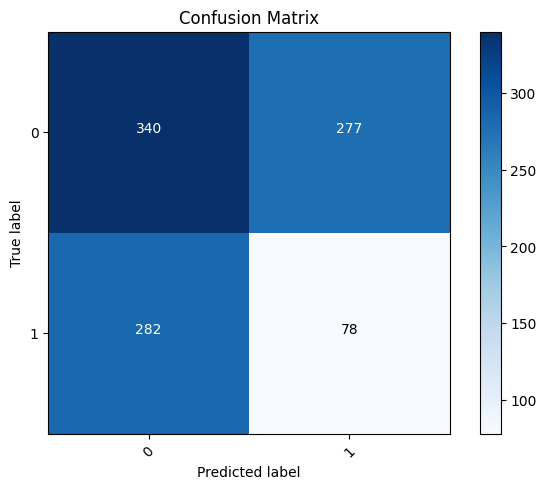

In [ ]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))